# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [4156]:
import pandas as pd, numpy as np, time
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
import shap
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

## Auxiliary Plotting Functions

##### highlight_min()
Highlights minimum values for every dataframe column

In [3904]:
def highlight_min(data, color='mediumaquamarine'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

##### aux_plot_real_vs_pred()
Creates a df with test vs predicted values of R0 and creates a bar plot

In [4279]:
def aux_plot_real_vs_pred(approach, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(20)
    reg_real_vs_pred.plot(kind='bar', color=['darksalmon', 'cornflowerblue'],figsize=(10,5)).set_title('Predicted vs Actual Approach ' + str(approach+1))
    plt.show()

##### plot_aux()
Plots measured vs predicted values for R0s selected in trian and test together with the perfect fit line.

In [3906]:
def plot_aux(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[approach][0].scatter(y_test, y_pred, color='cornflowerblue')
    ax[approach][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][0].set_title('Test Set Approach' + str(approach+1))
    ax[approach][0].set_xlabel('Measured')
    ax[approach][0].set_ylabel('Predicted')
    
    ax[approach][1].scatter(y_train, y_pred_train, color='cadetblue')
    ax[approach][1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][1].set_xlabel('Measured')
    ax[approach][1].set_ylabel('Predicted')
    ax[approach][1].set_title('Train Set Approach' + str(approach+1))

##### plot_aux_dist()
Function that plots distribution of R0s predicted, test vs train

In [3907]:
def plot_aux_dist(approach, y_test, y_train, y_pred, y_pred_train, axes):
    
    y_test_pred = y_pred
    y_train_pred = y_pred_train

    test = y_test
    train = y_train

    res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
    res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
    res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
    res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

    res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
    res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
    res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
    res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)
    
    plot = sns.kdeplot(res_df_train['pred'], ax=axes[approach][0], color='orange')
    plot = sns.kdeplot(res_df_train['test'], ax=axes[approach][0])
    plot = sns.kdeplot(res_df_test['pred'], ax=axes[approach][1], color='orange')
    plot = sns.kdeplot(res_df_test['test'], ax=axes[approach][1])
    
    axes[approach][0].set_title('Test Set Approach' + str(approach+1))
    axes[approach][1].set_title('Train Set Approach' + str(approach+1))
    
    fig.tight_layout()

#### plot_aux_reg()
Auxiliary method for regresion plot values of R0 in relation with test vs train values

In [3908]:
def plot_aux_reg(approach, y_test_appch, y_pred, y_train_appch, y_pred_train, ax):
    
    sns.regplot(y_test_appch,y_pred,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "lightseagreen"}, ax=axes[approach][0]) \
            .set_title('Actual vs Predicted')
    sns.regplot(y_train_appch,y_pred_train,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "lightseagreen"}, ax=axes[approach][1]) \
            .set_title('Actual vs Predicted')

    axes[approach][0].set_title('Test Set Approach' + str(approach+1))
    axes[approach][1].set_title('Train Set Approach' + str(approach+1)) 

#### get_values_metric()
Returns dataframes ready to plot for coparison three models with three different approaches

In [3910]:
def get_values_metric(metric):
    
    df_scores_xgb_mape=pd.DataFrame()
    df_scores_xgb_mape['Train']=df_scores_xgb_train[metric]
    df_scores_xgb_mape['Test']=df_scores_xgb[metric]
    
    df_scores_lgbm_mape=pd.DataFrame()
    df_scores_lgbm_mape['Train']=df_scores_lgbm_train[metric]
    df_scores_lgbm_mape['Test']=df_scores_lgbm[metric]

    df_scores_ctb_mape=pd.DataFrame()
    df_scores_ctb_mape['Train']=df_scores_ctb_train[metric]
    df_scores_ctb_mape['Test']=df_scores_ctb[metric]
    
    return df_scores_xgb_mape,df_scores_lgbm_mape, df_scores_ctb_mape

## Read file and prepare data 

In [4199]:
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL_new_r0_chile.csv')
del df['Unnamed: 0']
df=df[['Code', 'Date', 'contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', '%youth_unemployment_total','excess_mortality',
      'accumulated', 'reproduction_rate']]
df = df.rename(columns={'excess_mortality': 'infected_rate'})
df=df[[c for c in df if c not in ['reproduction_rate']] 
       + ['reproduction_rate']]
df

,Code,Date,contact_tracing,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,...,Holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,infected_rate,accumulated,reproduction_rate
0,AUS,2020-03-29,2.00,0.71,8.98,-0.39,5.45,-2.86,8.33,0.00,...,0.00,21.35,0.14,8263000.00,85.90,nan,11.84,12.13,0.00,2.17
1,AUS,2020-04-05,2.00,-0.90,15.16,0.45,-1.06,-4.96,6.96,0.00,...,0.00,21.18,0.05,8263000.00,85.90,nan,11.84,11.31,0.00,2.33
2,AUS,2020-04-12,2.00,-10.59,22.02,5.10,-21.84,-14.84,-0.92,0.29,...,0.00,20.70,0.05,8263000.00,85.90,nan,11.84,6.36,0.01,2.28
3,AUS,2020-04-19,2.00,-32.16,-0.02,13.43,-48.78,-28.18,-22.82,2.00,...,0.00,21.09,0.07,8263000.00,85.90,nan,11.84,2.95,0.01,1.46
4,AUS,2020-04-26,2.00,-40.92,-12.35,17.61,-60.20,-39.33,-35.27,2.00,...,0.00,18.88,0.12,8263000.00,85.90,nan,11.84,5.75,0.01,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,USA,2021-04-11,1.00,-8.82,-4.24,7.04,-27.18,4.27,-25.78,1.00,...,0.00,7.62,0.07,75608000.00,82.06,36.96,8.30,nan,0.23,1.02
3582,USA,2021-04-18,1.00,-8.47,-4.00,6.63,-26.16,12.04,-24.88,1.00,...,0.00,10.03,0.09,75608000.00,82.06,42.60,8.30,nan,0.23,1.07
3583,USA,2021-04-25,1.00,-8.02,-0.14,6.45,-25.47,17.75,-27.98,1.00,...,0.00,nan,nan,75608000.00,82.06,48.92,8.30,nan,0.23,1.05
3584,USA,2021-05-02,1.00,-7.98,-1.82,5.82,-24.57,24.35,-26.43,1.00,...,0.00,nan,nan,75608000.00,82.06,55.57,8.30,nan,0.23,1.04


Text(0.5, 1.0, 'reproduction_rate')

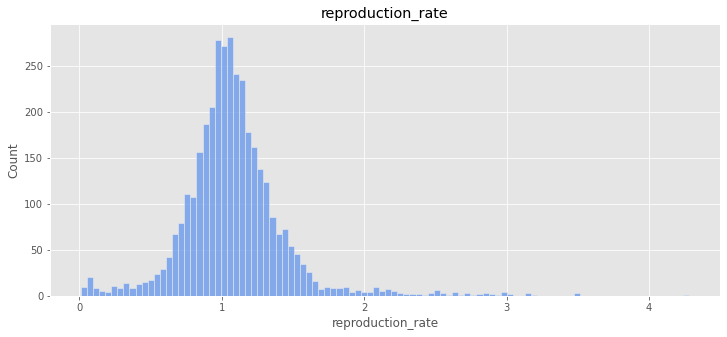

In [4200]:
#Removing -inf and infinite
df=df[~df.isin([np.inf, -np.inf]).any(1)]
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='reproduction_rate', data=df, kde=False, bins=100, ax=axes, color='cornflowerblue');
axes.set_title('reproduction_rate')

## Feature Engineering

### Approach 1: Raw data no grouping of variables or PCA Analysis
Train models with raw data, no previous transformation or grouping done

In [4237]:
df_appch1=df.copy()
df_appch1_clean=df.copy()

In [4238]:
df_appch1_clean['temp'] = df_appch1_clean['temp'].fillna(df_appch1_clean['temp'].mean())
df_appch1_clean['prcp'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['parks'] = df_appch1_clean['parks'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['number_of_arrivals'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['urban_population'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['total_vaccinations_per_100'] = df_appch1_clean['total_vaccinations_per_100'].fillna(0)
df_appch1_clean['%youth_unemployment_total']= df_appch1_clean['%youth_unemployment_total'].fillna(df_appch1_clean['%youth_unemployment_total'].mean())
df_appch1_clean = df_appch1_clean[df_appch1_clean['infected_rate'].notna()]
df_appch1_clean['accumulated']= df_appch1_clean['accumulated'].fillna(df_appch1_clean['accumulated'].mean())

### Approach 2: Grouping variables, decreasing dimensionality and correlation
Since variables seem to have high multicollinearity will group variables with similar corellation

In [4239]:
df_appch2=df.copy()

In [4240]:
#We define bad mobility as the weighted average of mobility trends that have a positive impact on covid spread
df_appch2['bad_mobility']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.2
                           +df_appch2['grocery_and_pharmacy']*0.2+df_appch2['workplaces']*0.2)

#We define good mobility as the weighted average of mobility trends that have a negative impact on covid spread
df_appch2['good_mobility']=(df_appch2['residential']*0.6+df_appch2['parks']*0.4)

df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['government_economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_measures']=df_appch2['stay_home_requirements'] + df_appch2['restriction_gatherings']\
                               +df_appch2['cancel_public_events'] + df_appch2['restrictions_internal_movements']\
                               +df_appch2['international_travel_controls'] + df_appch2['close_public_transport']\
                               +df_appch2['workplace_closures']+df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date','bad_mobility', 'good_mobility', 
                    'government_economic_measures', 'health_measures',
                     'mobility_measures', 'Holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                       'total_vaccinations_per_100', '%youth_unemployment_total',
                       'infected_rate', 'accumulated', 'reproduction_rate']]

In [4241]:
df_appch2.head()

,Code,Date,bad_mobility,good_mobility,government_economic_measures,health_measures,mobility_measures,Holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,infected_rate,accumulated,reproduction_rate
0,AUS,2020-03-29,4.84,-1.38,0.00,1.50,3.00,0.00,21.35,0.14,8263000.00,85.90,nan,11.84,12.13,0.00,2.17
1,AUS,2020-04-05,3.85,-1.71,0.50,1.50,4.43,0.00,21.18,0.05,8263000.00,85.90,nan,11.84,11.31,0.00,2.33
2,AUS,2020-04-12,-4.38,-2.87,0.64,1.50,12.14,0.00,20.70,0.05,8263000.00,85.90,nan,11.84,6.36,0.01,2.28
3,AUS,2020-04-19,-27.19,-3.22,1.50,1.50,17.57,0.00,21.09,0.07,8263000.00,85.90,nan,11.84,2.95,0.01,1.46
4,AUS,2020-04-26,-37.93,-5.16,1.50,1.50,19.00,0.00,18.88,0.12,8263000.00,85.90,nan,11.84,5.75,0.01,0.77


<AxesSubplot:>

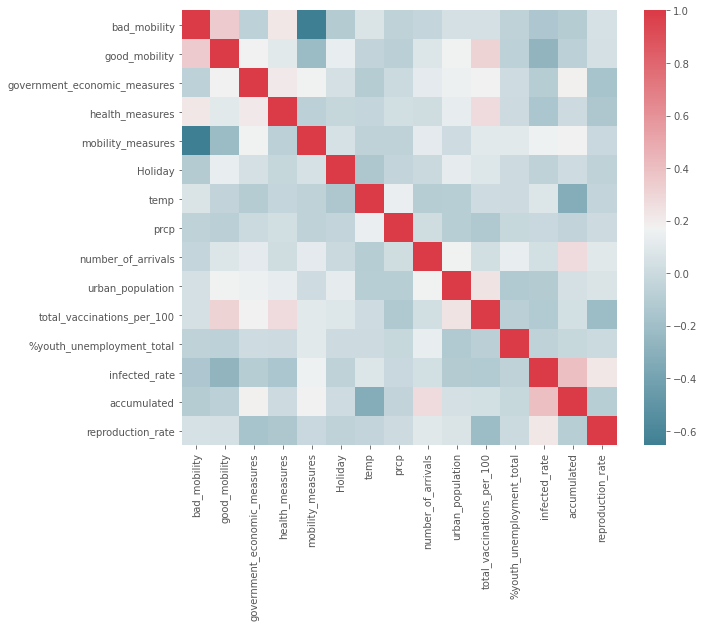

In [4242]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_appch2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [4243]:
df_appch2_clean=df_appch2.copy()
df_appch2_clean = df_appch2_clean[df_appch2_clean['bad_mobility'].notna()]
df_appch2_clean = df_appch2_clean[df_appch2_clean['good_mobility'].notna()]
df_appch2_clean['temp'] = df_appch2_clean['temp'].fillna(df_appch2_clean['temp'].mean())
df_appch2_clean['prcp'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['number_of_arrivals'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['urban_population'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['total_vaccinations_per_100'] = df_appch2_clean['total_vaccinations_per_100'].fillna(0)
df_appch2_clean['%youth_unemployment_total']= df_appch2_clean['%youth_unemployment_total'].fillna(df_appch2_clean['%youth_unemployment_total'].mean())
df_appch2_clean = df_appch2_clean[df_appch2_clean['infected_rate'].notna()]
df_appch2_clean['accumulated']= df_appch2_clean['accumulated'].fillna(df_appch2_clean['accumulated'].mean())

### Approach 3: PCA
Since variables have a high correlation we will group variables taking use of Principal Component Analysis

In [4244]:
df_appch3=df.copy()
df_appch3['total_vaccinations_per_100'] = df_appch3['total_vaccinations_per_100'].fillna(0)
df_appch3['accumulated'] = df_appch3['accumulated'].fillna(0)
df_appch3['urban_population'] = df_appch3['urban_population'].fillna(df_appch3['urban_population'].mean())
df_appch3['parks'] = df_appch3['parks'].fillna(df_appch3['parks'].mean())
df_appch3['temp'] = df_appch3['temp'].fillna(df_appch3['temp'].mean())
df_appch3['prcp'] = df_appch3['prcp'].fillna(df_appch3['prcp'].mean())
df_appch3 = df_appch3[df_appch3['retail_and_recreation'].notna()]
df_appch3 = df_appch3[df_appch3['grocery_and_pharmacy'].notna()]
df_appch3['%youth_unemployment_total']= df_appch3['%youth_unemployment_total'].fillna(df_appch3['%youth_unemployment_total'].mean())
df_appch3['number_of_arrivals']=df_appch3['number_of_arrivals'].fillna(df_appch3['number_of_arrivals'].mean())
df_appch3 = df_appch3[df_appch3['infected_rate'].notna()]


In [4245]:
df_appch3.columns

Index(['Code', 'Date', 'contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', '%youth_unemployment_total',
       'infected_rate', 'accumulated', 'reproduction_rate'],
      dtype='object')

In [4246]:
features=['contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', '%youth_unemployment_total',
       'infected_rate', 'accumulated']

# Separating out the features
x = df_appch3.reindex(columns = features).values
# Separating out the target
y = df_appch3.reindex(columns = ['reproduction_rate']).values
# Standardizing the features
x = StandardScaler().fit_transform(x)

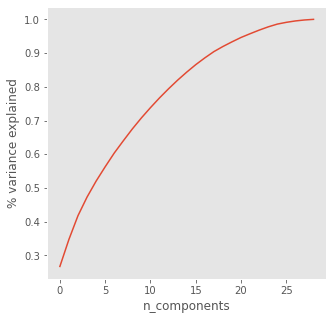

In [4247]:
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [4248]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 12)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#Include Date and R0 for later filtering
principalDf['Date']=df_appch3['Date']
principalDf['reproduction_rate']=df_appch3['reproduction_rate']
df_appch3=principalDf

## Modelling and Evaluation

Once we have our three datasets defined and have an intuition on how our trees should look like will start with the modelling and evaluation phase

In [4257]:
date=pd.Timestamp(2021, 1, 10)

#### Approach 1: Raw data no grouping of variables or PCA Analysis Split

In [4258]:
X_1=df_appch1[(pd.to_datetime(df_appch1['Date']) <= date)]
X_2=df_appch1[(pd.to_datetime(df_appch1['Date']) > date)]
X_train_appch1=X_1[X_1.columns[2:-1]]
X_test_appch1=X_2[X_2.columns[2:-1]]
y_train_appch1=X_1['reproduction_rate']
y_test_appch1=X_2['reproduction_rate']

In [4259]:
X_1_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) <= date)]
X_2_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch1_clean[df_appch1_clean.columns[2:-1]])

X_train_appch1_clean = scaler.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch1_clean = scaler.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch1_clean=X_1_clean['reproduction_rate']
y_test_appch1_clean=X_2_clean['reproduction_rate']

####  Approach 2: Grouping variables, decreasing dimensionality and correlation Split

In [4260]:
X_1=df_appch2[(pd.to_datetime(df_appch2['Date']) <= date)]
X_2=df_appch2[(pd.to_datetime(df_appch2['Date']) > date)]
X_train_appch2=X_1[X_1.columns[2:-1]]
X_test_appch2=X_2[X_2.columns[2:-1]]
y_train_appch2=X_1['reproduction_rate']
y_test_appch2=X_2['reproduction_rate']

In [4261]:
X_1_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) <= date)]
X_2_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch2_clean[df_appch2_clean.columns[2:-1]])

X_train_appch2_clean = scaler.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch2_clean = scaler.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch2_clean=X_1_clean['reproduction_rate']
y_test_appch2_clean=X_2_clean['reproduction_rate']

#### Approach 3: PCA  Split

In [4262]:
X_1=df_appch3[(pd.to_datetime(df_appch3['Date']) <= date)]
X_2=df_appch3[(pd.to_datetime(df_appch3['Date']) > date)]
X_train_appch3=X_1[X_1.columns[0:-2]]
X_test_appch3=X_2[X_2.columns[0:-2]]
y_train_appch3=X_1['reproduction_rate']
y_test_appch3=X_2['reproduction_rate']

In [4263]:
X_train_appch3_clean=X_train_appch3
X_test_appch3_clean=X_test_appch3
y_train_appch3_clean=y_train_appch3
y_test_appch3_clean=y_test_appch3

#### Check best parameters for our trees to avoid overfitting

Initial approach on max depth and n_trees

In [4221]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   24.3s finished


Best: 62.891104 using {'max_depth': 4, 'n_estimators': 100}
53.220055 (29.135860) with: {'max_depth': 4, 'n_estimators': 1}
54.560299 (57.188541) with: {'max_depth': 4, 'n_estimators': 20}
60.434077 (65.683424) with: {'max_depth': 4, 'n_estimators': 50}
62.891104 (67.773020) with: {'max_depth': 4, 'n_estimators': 100}
52.983359 (27.946375) with: {'max_depth': 6, 'n_estimators': 1}
56.600190 (60.681538) with: {'max_depth': 6, 'n_estimators': 20}
60.855203 (64.964065) with: {'max_depth': 6, 'n_estimators': 50}
61.213424 (64.628899) with: {'max_depth': 6, 'n_estimators': 100}
52.907625 (26.836552) with: {'max_depth': 8, 'n_estimators': 1}
54.517568 (54.946418) with: {'max_depth': 8, 'n_estimators': 20}
55.860171 (56.589694) with: {'max_depth': 8, 'n_estimators': 50}
56.530445 (57.766251) with: {'max_depth': 8, 'n_estimators': 100}
53.021995 (26.540372) with: {'max_depth': 10, 'n_estimators': 1}
55.976525 (55.987315) with: {'max_depth': 10, 'n_estimators': 20}
56.715963 (56.283765) with: {

Text(0, 0.5, 'MAPE')

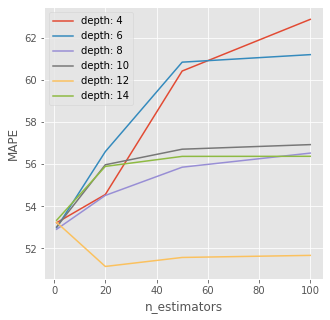

In [4222]:
n_estimators = [1,20,50,100]
max_depth = [4,6,8,10, 12, 14]

model = XGBRegressor() 

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

grid_search = GridSearchCV(model, param_grid, scoring=make_scorer(mape), n_jobs=-1, verbose=1)

grid_result = grid_search.fit(X_train_appch2, y_train_appch2)

# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('MAPE')

As seen, best range of estimators seems to be [100, 120] with a max_depth in range [4,6], other combinations may end up with bad results or overfitting

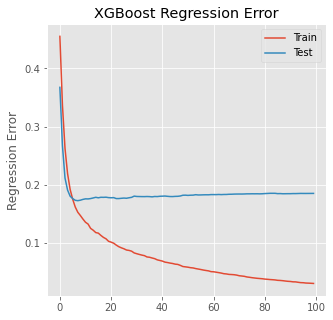

In [4223]:
#Default is created with max_depth 6 and n_estimators 100 which is correct for the following analysis
model = XGBRegressor()

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
model.fit(X_train_appch1, y_train_appch1, eval_metric=["mae"], eval_set=eval_set1, verbose=False)


results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()

## XGBoost Regressor 

### Modelling
We will model with the restriction observed in the previous section analyzing posible tuning in the parameters for Grid Search CV, for each of the three different approaches

In [4224]:
# A parameter grid for XGBoost
fit_params1={'n_estimators':[18,20,22],'max_depth' : [4,6,8]}
fit_params2={'n_estimators':[18,20,22],'max_depth' : [4,6,8]}
fit_params3={'n_estimators':[18,20,22],'max_depth' : [4,6,8]}

# Initialize XGB and GridSearch
xgb = XGBRegressor() 

grid1 = GridSearchCV(xgb, fit_params1, verbose=0, n_jobs=-1, scoring='neg_mean_absolute_error')
grid2 = GridSearchCV(xgb, fit_params2, verbose=0, n_jobs=-1,  scoring='neg_mean_absolute_error')
grid3 = GridSearchCV(xgb, fit_params3, verbose=0, n_jobs=-1,  scoring='neg_mean_absolute_error')

In [4225]:
%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, early_stopping_rounds=5, verbose=False)
grid2.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, early_stopping_rounds=5, verbose=False)
grid3.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, early_stopping_rounds=5, verbose=False)

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 11 µs


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [4226]:
y_pred_1=grid1.best_estimator_.predict(X_test_appch1)
y_pred_train_1=grid1.best_estimator_.predict(X_train_appch1)
y_pred_2=grid2.best_estimator_.predict(X_test_appch2)
y_pred_train_2=grid2.best_estimator_.predict(X_train_appch2)
y_pred_3=grid3.best_estimator_.predict(X_test_appch3)
y_pred_train_3=grid3.best_estimator_.predict(X_train_appch3)

In [4227]:
grid2.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=18, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### XGB Evaluation

#### Test Set

In [4228]:
mae_1 = mean_absolute_error(y_test_appch1, y_pred_1)
mse_1 = mean_squared_error(y_test_appch1, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test_appch1, y_pred_1))
r2_1 = r2_score(y_test_appch1, y_pred_1)
mape_1 = np.mean(np.abs((y_test_appch1 - y_pred_1) / y_test_appch1)) * 100

mae_2 = mean_absolute_error(y_test_appch2, y_pred_2)
mse_2 = mean_squared_error(y_test_appch2, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_appch2, y_pred_2))
r2_2 = r2_score(y_test_appch2, y_pred_2)
mape_2 = np.mean(np.abs((y_test_appch2 - y_pred_2) / y_test_appch2)) * 100

mae_3 = mean_absolute_error(y_test_appch3, y_pred_3)
mse_3 = mean_squared_error(y_test_appch3, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test_appch3, y_pred_3))
r2_3 = r2_score(y_test_appch3, y_pred_3)
mape_3 = np.mean(np.abs((y_test_appch3 - y_pred_3) / y_test_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_xgb=pd.DataFrame(scores)
df_scores_xgb.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.17,0.05,0.23,0.01,33.97
Approach 2,0.19,0.07,0.26,-0.23,34.80
Approach 3,0.14,0.03,0.18,-0.20,15.15


#### Train Set

In [4272]:
mae_1 = mean_absolute_error(y_train_appch1, y_pred_train_1)
mse_1 = mean_squared_error(y_train_appch1, y_pred_train_1)
rmse_1 = np.sqrt(mean_squared_error(y_train_appch1, y_pred_train_1))
r2_1 = r2_score(y_train_appch1, y_pred_train_1)
mape_1 = np.mean(np.abs((y_train_appch1 - y_pred_train_1) / y_train_appch1)) * 100

mae_2 = mean_absolute_error(y_train_appch2, y_pred_train_2)
mse_2 = mean_squared_error(y_train_appch2, y_pred_train_2)
rmse_2 = np.sqrt(mean_squared_error(y_train_appch2, y_pred_train_2))
r2_2 = r2_score(y_train_appch2, y_pred_train_2)
mape_2 = np.mean(np.abs((y_train_appch2 - y_pred_train_2) / y_train_appch2)) * 100

mae_3 = mean_absolute_error(y_train_appch3, y_pred_train_3)
mse_3 = mean_squared_error(y_train_appch3, y_pred_train_3)
rmse_3 = np.sqrt(mean_squared_error(y_train_appch3, y_pred_train_3))
r2_3 = r2_score(y_train_appch3, y_pred_train_3)
mape_3 = np.mean(np.abs((y_train_appch3 - y_pred_train_3) / y_train_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_xgb_train=pd.DataFrame(scores)
df_scores_xgb_train.style.apply(highlight_min)

ValueError: Found input variables with inconsistent numbers of samples: [2483, 1818]

## Results View

#### Actual vs Predicted

In [4271]:
aux_plot_real_vs_pred(0, y_test_appch1, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3, y_pred_3)

ValueError: array length 399 does not match index length 1103

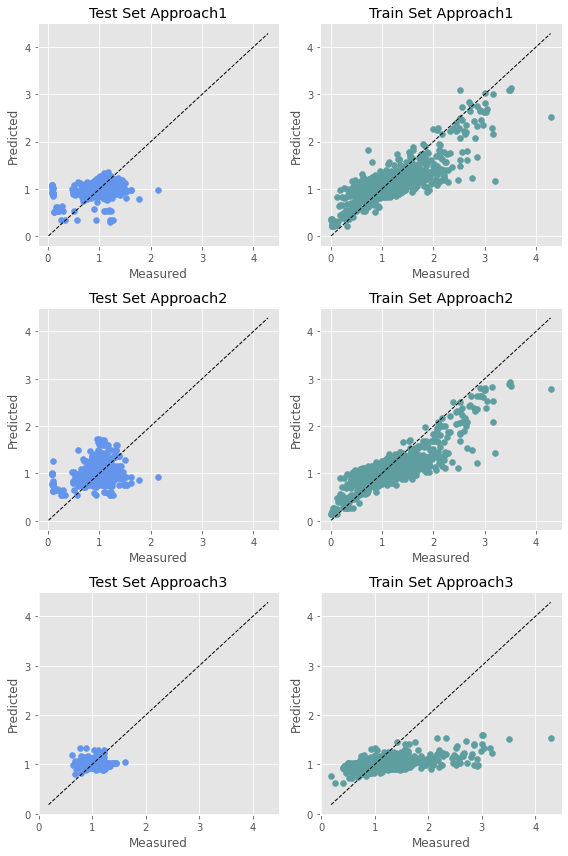

In [4232]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1, y_pred_1, y_train_appch1, y_pred_train_1, ax)
plot_aux(1, y_test_appch2, y_pred_2, y_train_appch2, y_pred_train_2, ax)
plot_aux(2, y_test_appch3, y_pred_3, y_train_appch3, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

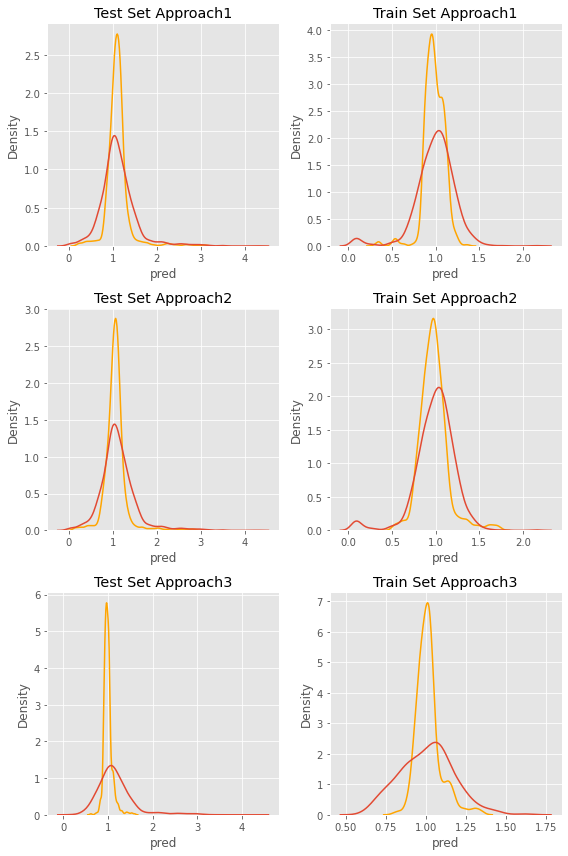

In [4233]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1, y_train_appch1, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2, y_train_appch2, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3, y_train_appch3, y_pred_3, y_pred_train_3, ax)

plt.show()

## Light GBM

### Modelling 

In [3501]:
fit_params1={'n_estimators':[40,50,60],'max_depth' : [10,12,14]}
fit_params2={'n_estimators':[40,50,60],'max_depth' : [10,12,14]}
fit_params3={'n_estimators':[40,50,60],'max_depth' : [10,12,14]}


# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid1 = GridSearchCV(lgbm, fit_params1, verbose=0)
grid2 = GridSearchCV(lgbm, fit_params2, verbose=0)
grid3 = GridSearchCV(lgbm, fit_params3, verbose=0)

In [3502]:
%%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, verbose=False)
grid2.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, verbose=False)
grid3.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, verbose=False)

CPU times: user 1min 16s, sys: 4.55 s, total: 1min 20s
Wall time: 34.2 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [10, 12, 14],
                         'n_estimators': [40, 50, 60]})

In [3503]:
y_pred_1=grid1.best_estimator_.predict(X_test_appch1)
y_pred_train_1=grid1.best_estimator_.predict(X_train_appch1)
y_pred_2=grid2.best_estimator_.predict(X_test_appch2)
y_pred_train_2=grid2.best_estimator_.predict(X_train_appch2)
y_pred_3=grid3.best_estimator_.predict(X_test_appch3)
y_pred_train_3=grid3.best_estimator_.predict(X_train_appch3)

### Evaluation

In [3506]:
mae_1 = mean_absolute_error(y_test_appch1, y_pred_1)
mse_1 = mean_squared_error(y_test_appch1, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test_appch1, y_pred_1))
r2_1 = r2_score(y_test_appch1, y_pred_1)
mape_1 = np.mean(np.abs((y_test_appch1 - y_pred_1) / y_test_appch1)) * 100

mae_2 = mean_absolute_error(y_test_appch2, y_pred_2)
mse_2 = mean_squared_error(y_test_appch2, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_appch2, y_pred_2))
r2_2 = r2_score(y_test_appch2, y_pred_2)
mape_2 = np.mean(np.abs((y_test_appch2 - y_pred_2) / y_test_appch2)) * 100

mae_3 = mean_absolute_error(y_test_appch3, y_pred_3)
mse_3 = mean_squared_error(y_test_appch3, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test_appch3, y_pred_3))
r2_3 = r2_score(y_test_appch3, y_pred_3)
mape_3 = np.mean(np.abs((y_test_appch3 - y_pred_3) / y_test_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_lgbm=pd.DataFrame(scores)
df_scores_lgbm.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.169425,0.056441,0.237573,-0.068375,35.657438
Approach 2,0.173432,0.058926,0.242746,-0.115407,34.602889
Approach 3,0.242520,0.088392,0.297308,-2.165691,26.604505


#### Train Set

In [3507]:
mae_1 = mean_absolute_error(y_train_appch1, y_pred_train_1)
mse_1 = mean_squared_error(y_train_appch1, y_pred_train_1)
rmse_1 = np.sqrt(mean_squared_error(y_train_appch1, y_pred_train_1))
r2_1 = r2_score(y_train_appch1, y_pred_train_1)
mape_1 = np.mean(np.abs((y_train_appch1 - y_pred_train_1) / y_train_appch1)) * 100

mae_2 = mean_absolute_error(y_train_appch2, y_pred_train_2)
mse_2 = mean_squared_error(y_train_appch2, y_pred_train_2)
rmse_2 = np.sqrt(mean_squared_error(y_train_appch2, y_pred_train_2))
r2_2 = r2_score(y_train_appch2, y_pred_train_2)
mape_2 = np.mean(np.abs((y_train_appch2 - y_pred_train_2) / y_train_appch2)) * 100

mae_3 = mean_absolute_error(y_train_appch3, y_pred_train_3)
mse_3 = mean_squared_error(y_train_appch3, y_pred_train_3)
rmse_3 = np.sqrt(mean_squared_error(y_train_appch3, y_pred_train_3))
r2_3 = r2_score(y_train_appch3, y_pred_train_3)
mape_3 = np.mean(np.abs((y_train_appch3 - y_pred_train_3) / y_train_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_lgbm_train=pd.DataFrame(scores)
df_scores_lgbm_train.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.129965,0.032280,0.179667,0.804680,17.398962
Approach 2,0.135196,0.035226,0.187685,0.786857,18.295799
Approach 3,0.150657,0.052620,0.229389,0.702884,13.954868


## Results View

#### Actual vs Predicted

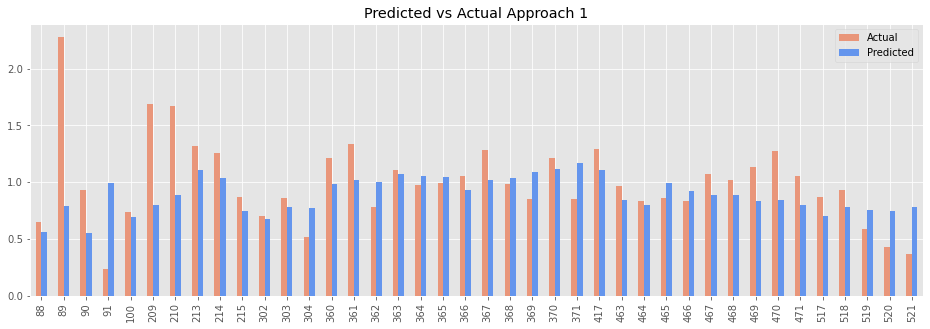

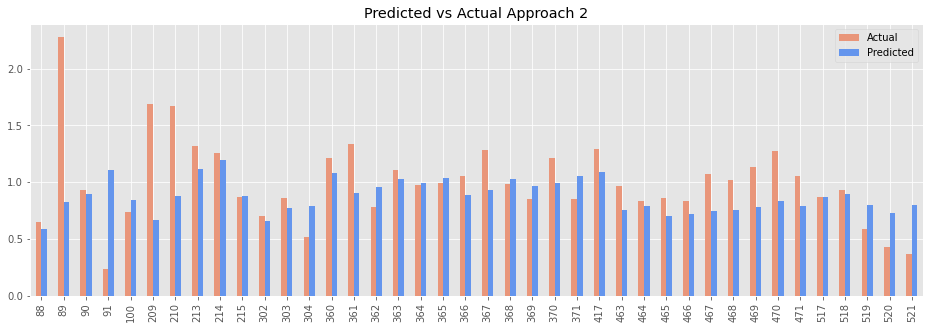

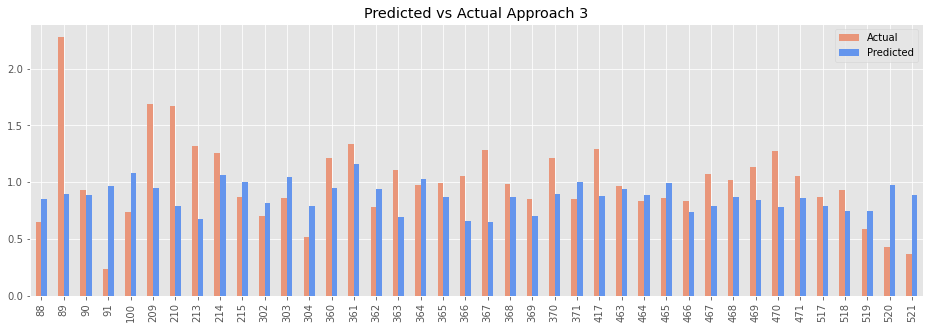

In [3305]:
aux_plot_real_vs_pred(0, y_test_appch1, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3, y_pred_3)

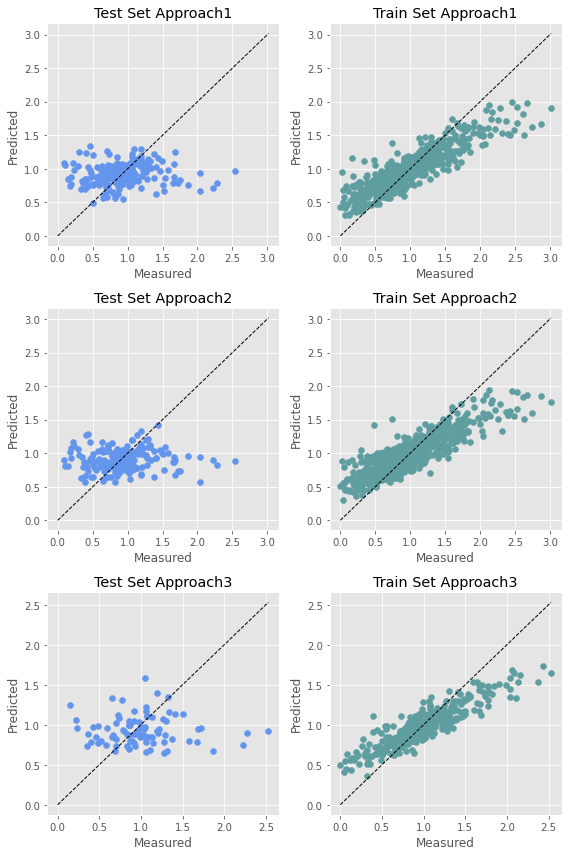

In [3307]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1, y_pred_1, y_train_appch1, y_pred_train_1, ax)
plot_aux(1, y_test_appch2, y_pred_2, y_train_appch2, y_pred_train_2, ax)
plot_aux(2, y_test_appch3, y_pred_3, y_train_appch3, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

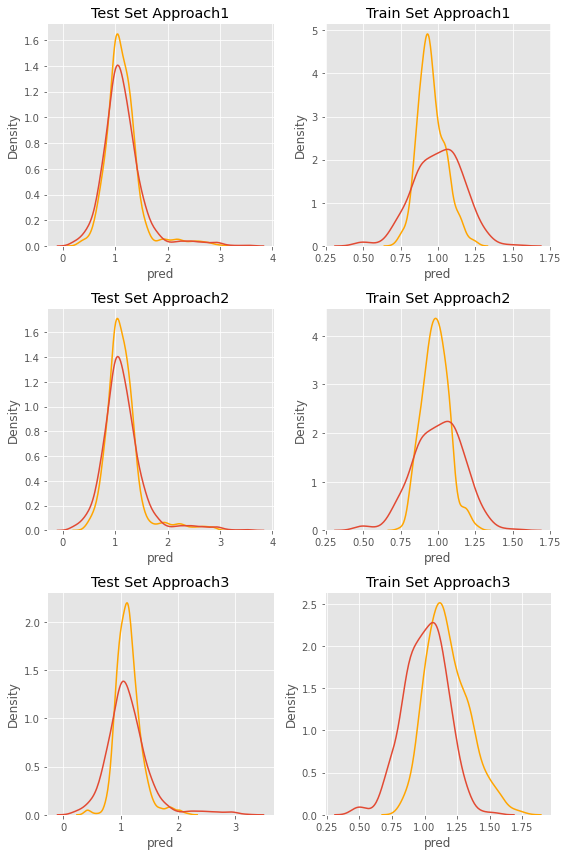

In [3205]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1, y_train_appch1, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2, y_train_appch2, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3, y_train_appch3, y_pred_3, y_pred_train_3, ax)

plt.show()

## CatBoost Regressor 

In [3206]:
model = CatBoostRegressor(eval_metric='MAPE')
#parameters1 = {'depth': [10,12,14],'iterations': [30, 50, 100]}
#parameters2 = {'depth': [10,12,14],'iterations': [30, 50, 100]}
#parameters3 = {'depth': [10,12,14],'iterations': [30, 50, 100]}

parameters1 = {}
parameters2 = {}
parameters3 = {}

grid1 = GridSearchCV(estimator=model, param_grid = parameters1, cv = 2, n_jobs=-1)
grid2 = GridSearchCV(estimator=model, param_grid = parameters2, cv = 2, n_jobs=-1)
grid3 = GridSearchCV(estimator=model, param_grid = parameters3, cv = 2, n_jobs=-1)

In [3207]:
%%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, verbose=False)
grid2.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, verbose=False)
grid3.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, verbose=False)

CPU times: user 27.4 s, sys: 1.63 s, total: 29 s
Wall time: 30.2 s


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7ff174861310>,
             n_jobs=-1, param_grid={})

In [3208]:
y_pred_1=grid1.best_estimator_.predict(X_test_appch1)
y_pred_train_1=grid1.best_estimator_.predict(X_train_appch1)
y_pred_2=grid2.best_estimator_.predict(X_test_appch2)
y_pred_train_2=grid2.best_estimator_.predict(X_train_appch2)
y_pred_3=grid3.best_estimator_.predict(X_test_appch3)
y_pred_train_3=grid3.best_estimator_.predict(X_train_appch3)

### Evaluation

#### Test Set

In [3209]:
mae_1 = mean_absolute_error(y_test_appch1, y_pred_1)
mse_1 = mean_squared_error(y_test_appch1, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test_appch1, y_pred_1))
r2_1 = r2_score(y_test_appch1, y_pred_1)
mape_1 = np.mean(np.abs((y_test_appch1 - y_pred_1) / y_test_appch1)) * 100

mae_2 = mean_absolute_error(y_test_appch2, y_pred_2)
mse_2 = mean_squared_error(y_test_appch2, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_appch2, y_pred_2))
r2_2 = r2_score(y_test_appch2, y_pred_2)
mape_2 = np.mean(np.abs((y_test_appch2 - y_pred_2) / y_test_appch2)) * 100

mae_3 = mean_absolute_error(y_test_appch3, y_pred_3)
mse_3 = mean_squared_error(y_test_appch3, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test_appch3, y_pred_3))
r2_3 = r2_score(y_test_appch3, y_pred_3)
mape_3 = np.mean(np.abs((y_test_appch3 - y_pred_3) / y_test_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3} }
    
df_scores_ctb=pd.DataFrame(scores)
df_scores_ctb.style.apply(highlight_min)

,mae,mse,rmse,mape
Approach 1,0.115108,0.022329,0.149428,12.509598
Approach 2,0.119709,0.024362,0.156082,12.610980
Approach 3,0.165081,0.043650,0.208926,19.192039


#### Train Set

In [3210]:
mae_1 = mean_absolute_error(y_train_appch1, y_pred_train_1)
mse_1 = mean_squared_error(y_train_appch1, y_pred_train_1)
rmse_1 = np.sqrt(mean_squared_error(y_train_appch1, y_pred_train_1))
r2_1 = r2_score(y_train_appch1, y_pred_train_1)
mape_1 = np.mean(np.abs((y_train_appch1 - y_pred_train_1) / y_train_appch1)) * 100

mae_2 = mean_absolute_error(y_train_appch2, y_pred_train_2)
mse_2 = mean_squared_error(y_train_appch2, y_pred_train_2)
rmse_2 = np.sqrt(mean_squared_error(y_train_appch2, y_pred_train_2))
r2_2 = r2_score(y_train_appch2, y_pred_train_2)
mape_2 = np.mean(np.abs((y_train_appch2 - y_pred_train_2) / y_train_appch2)) * 100

mae_3 = mean_absolute_error(y_train_appch3, y_pred_train_3)
mse_3 = mean_squared_error(y_train_appch3, y_pred_train_3)
rmse_3 = np.sqrt(mean_squared_error(y_train_appch3, y_pred_train_3))
r2_3 = r2_score(y_train_appch3, y_pred_train_3)
mape_3 = np.mean(np.abs((y_train_appch3 - y_pred_train_3) / y_train_appch3)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3} }
    
df_scores_ctb_train=pd.DataFrame(scores)
df_scores_ctb_train.style.apply(highlight_min)

,mae,mse,rmse,mape
Approach 1,0.181938,0.062300,0.249600,19.215352
Approach 2,0.124913,0.027975,0.167258,12.932973
Approach 3,0.273368,0.156982,0.396209,28.934582


## Results View

#### Actual vs Predicted

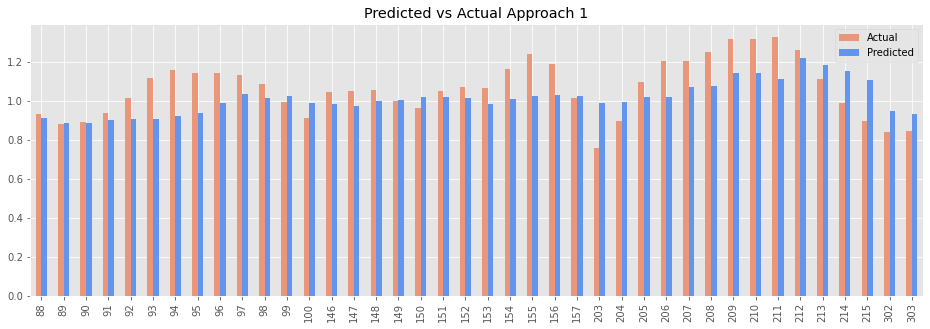

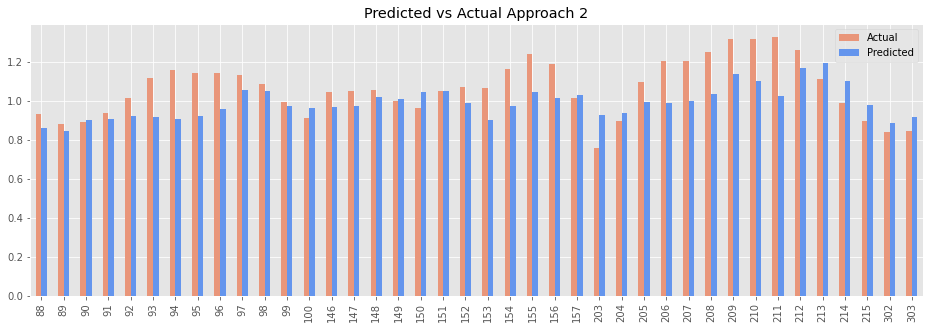

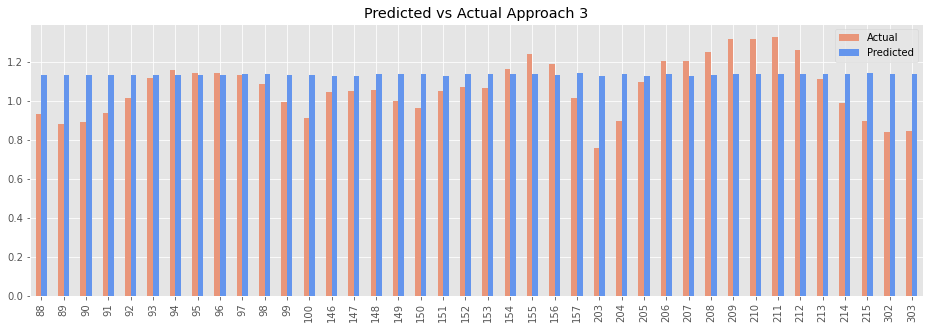

In [3211]:
aux_plot_real_vs_pred(0, y_test_appch1, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3,y_pred_3)

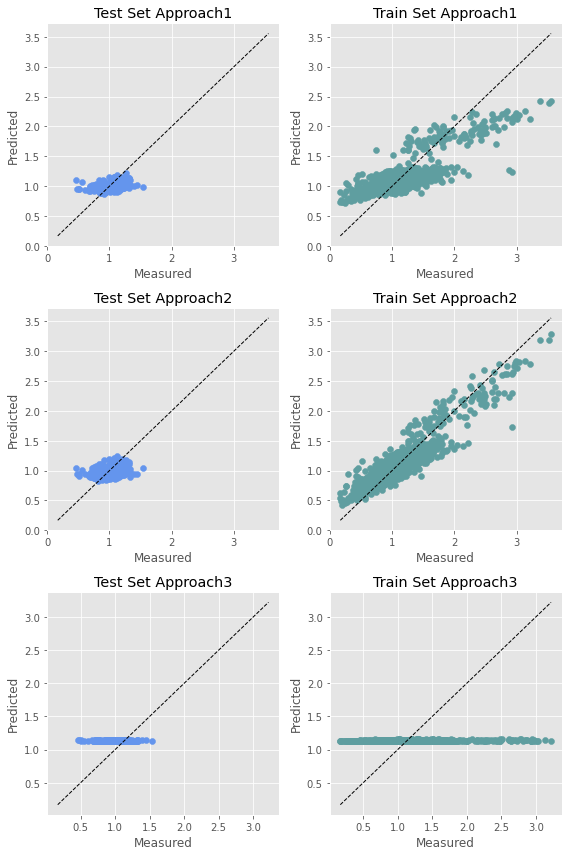

In [3213]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1, y_pred_1, y_train_appch1, y_pred_train_1, ax)
plot_aux(1, y_test_appch2, y_pred_2, y_train_appch2, y_pred_train_2, ax)
plot_aux(2, y_test_appch3, y_pred_3, y_train_appch3, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

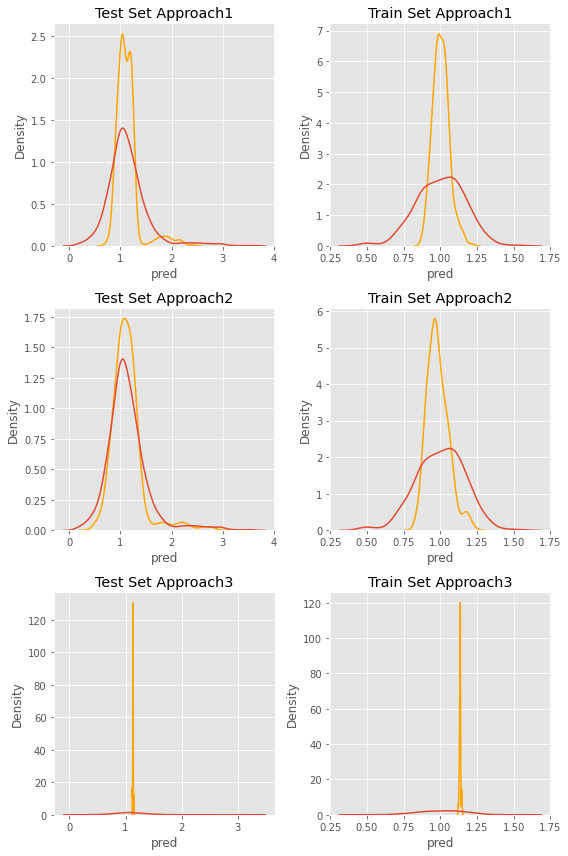

In [3214]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1, y_train_appch1, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2, y_train_appch2, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3, y_train_appch3, y_pred_3, y_pred_train_3, ax)

plt.show()

## Gradient Boosting Regressor 

In [4280]:
reg1 = GradientBoostingRegressor()
reg2 = GradientBoostingRegressor()
reg3 = GradientBoostingRegressor()

reg1.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3.fit(X_train_appch3_clean, y_train_appch3_clean)


y_pred_1=reg1.predict(X_test_appch1_clean)
y_pred_train_1=reg1.predict(X_train_appch1_clean)
y_pred_2=reg2.predict(X_test_appch2_clean)
y_pred_train_2=reg2.predict(X_train_appch2_clean)
y_pred_3=reg3.predict(X_test_appch3_clean)
y_pred_train_3=reg3.predict(X_train_appch3_clean)

### Evaluation

In [4281]:
mae_1 = mean_absolute_error(y_test_appch1_clean, y_pred_1)
mse_1 = mean_squared_error(y_test_appch1_clean, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test_appch1_clean, y_pred_1))
r2_1 = r2_score(y_test_appch1_clean, y_pred_1)
mape_1 = np.mean(np.abs((y_test_appch1_clean - y_pred_1) / y_test_appch1_clean)) * 100

mae_2 = mean_absolute_error(y_test_appch2_clean, y_pred_2)
mse_2 = mean_squared_error(y_test_appch2_clean, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_appch2_clean, y_pred_2))
r2_2 = r2_score(y_test_appch2_clean, y_pred_2)
mape_2 = np.mean(np.abs((y_test_appch2_clean - y_pred_2) / y_test_appch2_clean)) * 100

mae_3 = mean_absolute_error(y_test_appch3_clean, y_pred_3)
mse_3 = mean_squared_error(y_test_appch3_clean, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test_appch3_clean, y_pred_3))
r2_3 = r2_score(y_test_appch3_clean, y_pred_3)
mape_3 = np.mean(np.abs((y_test_appch3_clean - y_pred_3) / y_test_appch3_clean)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_lgbm=pd.DataFrame(scores)
df_scores_lgbm.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.15,0.04,0.19,-0.15,14.68
Approach 2,0.16,0.04,0.21,-0.40,16.27
Approach 3,0.22,0.07,0.27,-1.63,24.61


#### Train Set

In [4282]:
mae_1 = mean_absolute_error(y_train_appch1_clean, y_pred_train_1)
mse_1 = mean_squared_error(y_train_appch1_clean, y_pred_train_1)
rmse_1 = np.sqrt(mean_squared_error(y_train_appch1_clean, y_pred_train_1))
r2_1 = r2_score(y_train_appch1_clean, y_pred_train_1)
mape_1 = np.mean(np.abs((y_train_appch1_clean - y_pred_train_1) / y_train_appch1_clean)) * 100

mae_2 = mean_absolute_error(y_train_appch2_clean, y_pred_train_2)
mse_2 = mean_squared_error(y_train_appch2_clean, y_pred_train_2)
rmse_2 = np.sqrt(mean_squared_error(y_train_appch2_clean, y_pred_train_2))
r2_2 = r2_score(y_train_appch2_clean, y_pred_train_2)
mape_2 = np.mean(np.abs((y_train_appch2_clean - y_pred_train_2) / y_train_appch2_clean)) * 100

mae_3 = mean_absolute_error(y_train_appch3_clean, y_pred_train_3)
mse_3 = mean_squared_error(y_train_appch3_clean, y_pred_train_3)
rmse_3 = np.sqrt(mean_squared_error(y_train_appch3_clean, y_pred_train_3))
r2_3 = r2_score(y_train_appch3_clean, y_pred_train_3)
mape_3 = np.mean(np.abs((y_train_appch3_clean - y_pred_train_3) / y_train_appch3_clean)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_lgbm_train=pd.DataFrame(scores)
df_scores_lgbm_train.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.16,0.05,0.23,0.71,18.93
Approach 2,0.17,0.06,0.24,0.69,19.91
Approach 3,0.21,0.09,0.29,0.51,19.56


## Results View

#### Actual vs Predicted

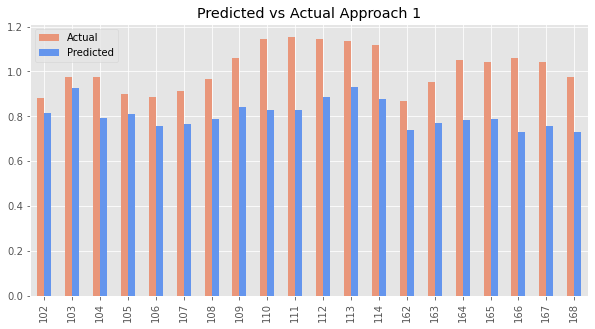

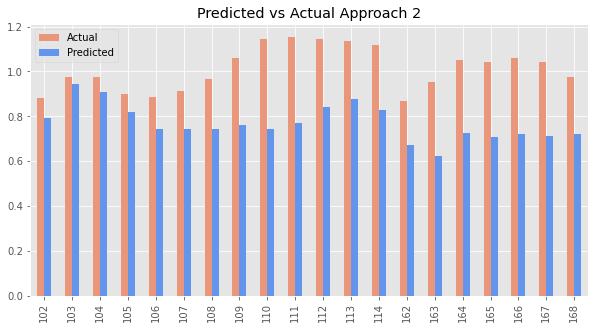

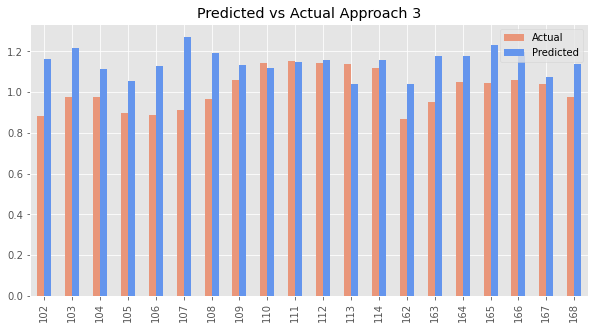

In [4283]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3_clean, y_pred_3)

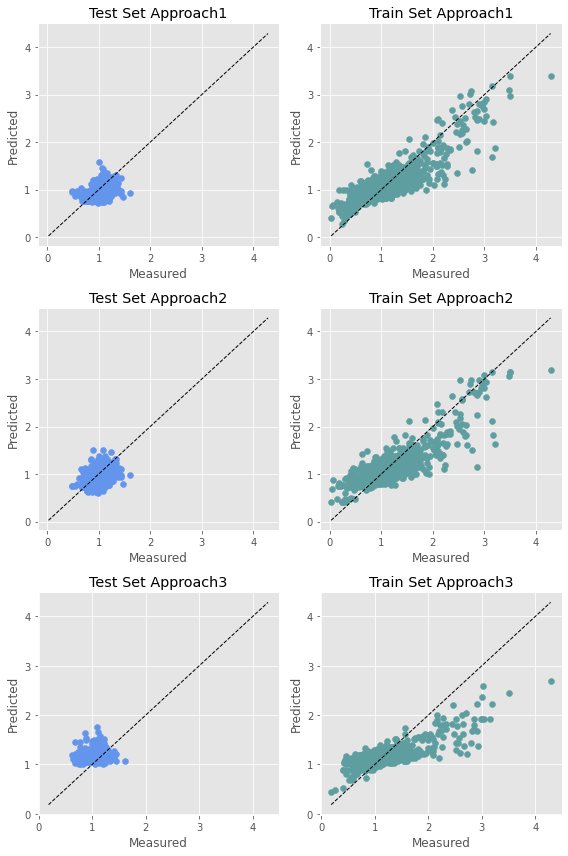

In [4284]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1_clean, y_pred_1, y_train_appch1_clean, y_pred_train_1, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2, y_train_appch2_clean, y_pred_train_2, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3, y_train_appch3_clean, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

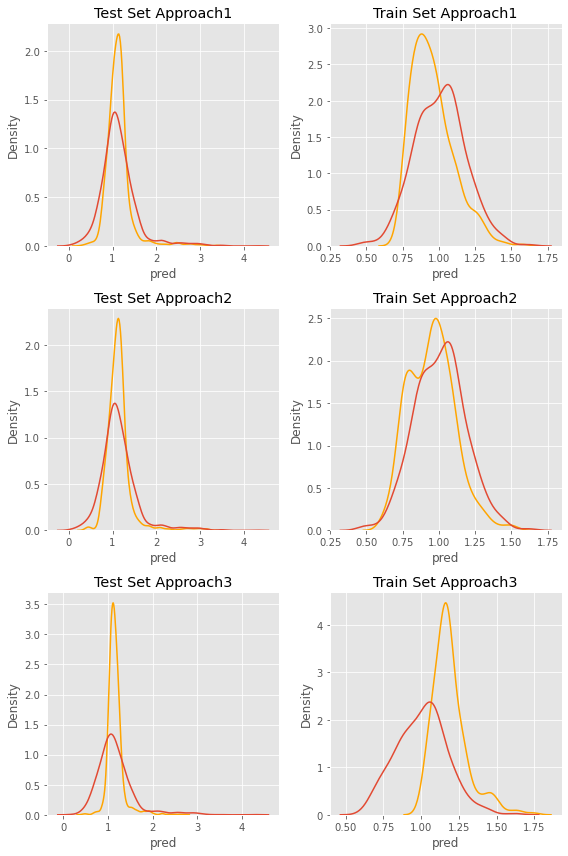

In [4278]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1_clean, y_train_appch1_clean, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2_clean, y_train_appch2_clean, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3_clean, y_train_appch3_clean, y_pred_3, y_pred_train_3, ax)

plt.show()

## Random Forest Regressor

In [4280]:
reg1 = GradientBoostingRegressor()
reg2 = GradientBoostingRegressor()
reg3 = GradientBoostingRegressor()

reg1.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3.fit(X_train_appch3_clean, y_train_appch3_clean)


y_pred_1=reg1.predict(X_test_appch1_clean)
y_pred_train_1=reg1.predict(X_train_appch1_clean)
y_pred_2=reg2.predict(X_test_appch2_clean)
y_pred_train_2=reg2.predict(X_train_appch2_clean)
y_pred_3=reg3.predict(X_test_appch3_clean)
y_pred_train_3=reg3.predict(X_train_appch3_clean)

### Evaluation

In [4281]:
mae_1 = mean_absolute_error(y_test_appch1_clean, y_pred_1)
mse_1 = mean_squared_error(y_test_appch1_clean, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test_appch1_clean, y_pred_1))
r2_1 = r2_score(y_test_appch1_clean, y_pred_1)
mape_1 = np.mean(np.abs((y_test_appch1_clean - y_pred_1) / y_test_appch1_clean)) * 100

mae_2 = mean_absolute_error(y_test_appch2_clean, y_pred_2)
mse_2 = mean_squared_error(y_test_appch2_clean, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_appch2_clean, y_pred_2))
r2_2 = r2_score(y_test_appch2_clean, y_pred_2)
mape_2 = np.mean(np.abs((y_test_appch2_clean - y_pred_2) / y_test_appch2_clean)) * 100

mae_3 = mean_absolute_error(y_test_appch3_clean, y_pred_3)
mse_3 = mean_squared_error(y_test_appch3_clean, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test_appch3_clean, y_pred_3))
r2_3 = r2_score(y_test_appch3_clean, y_pred_3)
mape_3 = np.mean(np.abs((y_test_appch3_clean - y_pred_3) / y_test_appch3_clean)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_lgbm=pd.DataFrame(scores)
df_scores_lgbm.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.15,0.04,0.19,-0.15,14.68
Approach 2,0.16,0.04,0.21,-0.40,16.27
Approach 3,0.22,0.07,0.27,-1.63,24.61


#### Train Set

In [4282]:
mae_1 = mean_absolute_error(y_train_appch1_clean, y_pred_train_1)
mse_1 = mean_squared_error(y_train_appch1_clean, y_pred_train_1)
rmse_1 = np.sqrt(mean_squared_error(y_train_appch1_clean, y_pred_train_1))
r2_1 = r2_score(y_train_appch1_clean, y_pred_train_1)
mape_1 = np.mean(np.abs((y_train_appch1_clean - y_pred_train_1) / y_train_appch1_clean)) * 100

mae_2 = mean_absolute_error(y_train_appch2_clean, y_pred_train_2)
mse_2 = mean_squared_error(y_train_appch2_clean, y_pred_train_2)
rmse_2 = np.sqrt(mean_squared_error(y_train_appch2_clean, y_pred_train_2))
r2_2 = r2_score(y_train_appch2_clean, y_pred_train_2)
mape_2 = np.mean(np.abs((y_train_appch2_clean - y_pred_train_2) / y_train_appch2_clean)) * 100

mae_3 = mean_absolute_error(y_train_appch3_clean, y_pred_train_3)
mse_3 = mean_squared_error(y_train_appch3_clean, y_pred_train_3)
rmse_3 = np.sqrt(mean_squared_error(y_train_appch3_clean, y_pred_train_3))
r2_3 = r2_score(y_train_appch3_clean, y_pred_train_3)
mape_3 = np.mean(np.abs((y_train_appch3_clean - y_pred_train_3) / y_train_appch3_clean)) * 100

scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
           'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
           'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
           'r2' : {'Approach 1':r2_1, 'Approach 2':r2_2, 'Approach 3':r2_3},
           'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3}}
    
df_scores_lgbm_train=pd.DataFrame(scores)
df_scores_lgbm_train.style.apply(highlight_min)

,mae,mse,rmse,r2,mape
Approach 1,0.16,0.05,0.23,0.71,18.93
Approach 2,0.17,0.06,0.24,0.69,19.91
Approach 3,0.21,0.09,0.29,0.51,19.56


## Results View

#### Actual vs Predicted

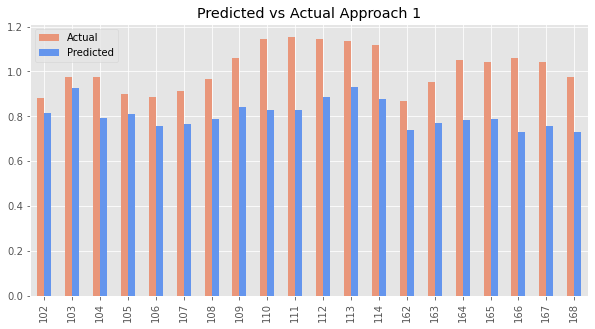

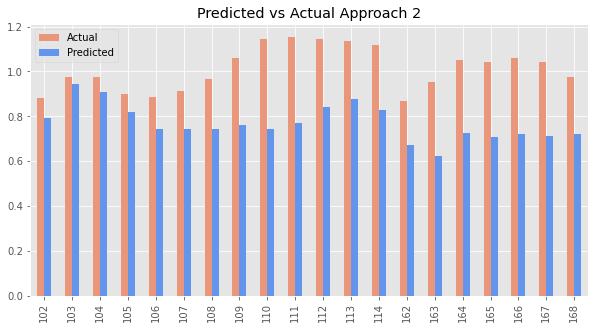

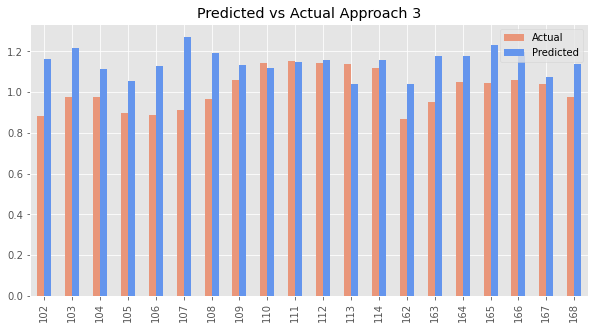

In [4283]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2_clean, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3_clean, y_pred_3)

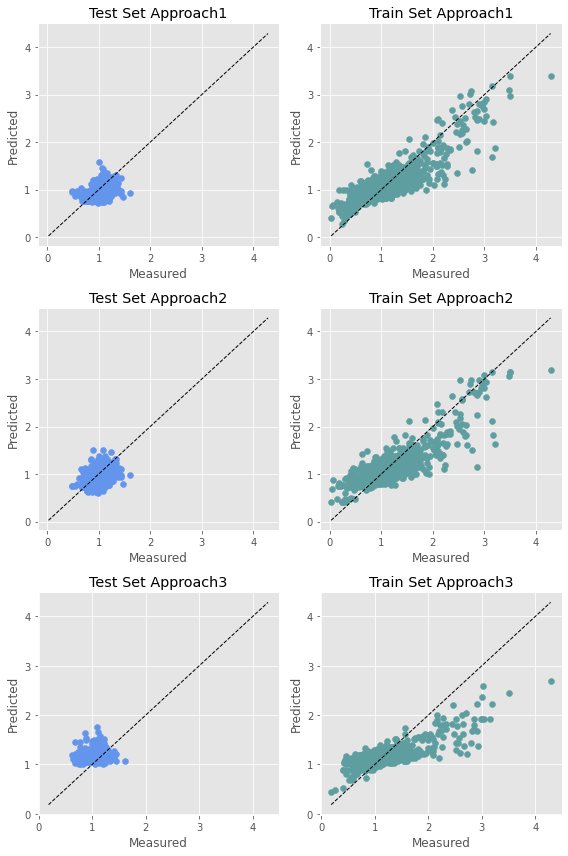

In [4284]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1_clean, y_pred_1, y_train_appch1_clean, y_pred_train_1, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2, y_train_appch2_clean, y_pred_train_2, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3, y_train_appch3_clean, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

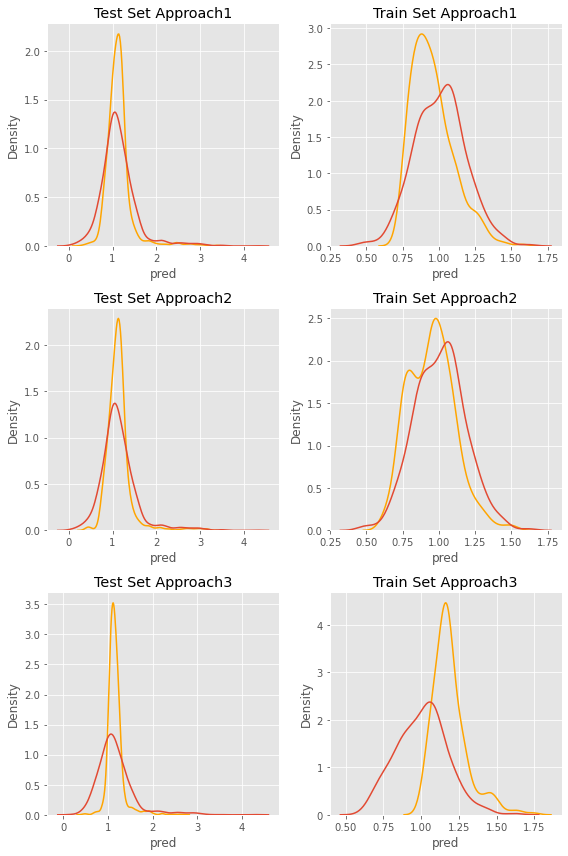

In [4278]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1_clean, y_train_appch1_clean, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2_clean, y_train_appch2_clean, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3_clean, y_train_appch3_clean, y_pred_3, y_pred_train_3, ax)

plt.show()

## Comparing Three Models with Three Approaches

In [3215]:
xgb_mae, lgb_mae, ctb_mae = get_values_metric('mae')
xgb_mse, lgb_mse, ctb_mse = get_values_metric('mse')
xgb_rmse, lgb_rmse, ctb_rmse = get_values_metric('rmse')
xgb_mape, lgb_mape, ctb_mape = get_values_metric('mape')

xgb_mae=xgb_mae.sort_index(ascending=False)
lgb_mae=lgb_mae.sort_index(ascending=False)
ctb_mae=ctb_mae.sort_index(ascending=False)

xgb_mse=xgb_mse.sort_index(ascending=False)
lgb_mse=lgb_mse.sort_index(ascending=False)
ctb_mse=ctb_mse.sort_index(ascending=False)

xgb_rmse=xgb_rmse.sort_index(ascending=False)
lgb_rmse=lgb_rmse.sort_index(ascending=False)
ctb_rmse=ctb_rmse.sort_index(ascending=False)

xgb_mape=xgb_mape.sort_index(ascending=False)
lgb_mape=lgb_mape.sort_index(ascending=False)
ctb_mape=ctb_mape.sort_index(ascending=False)

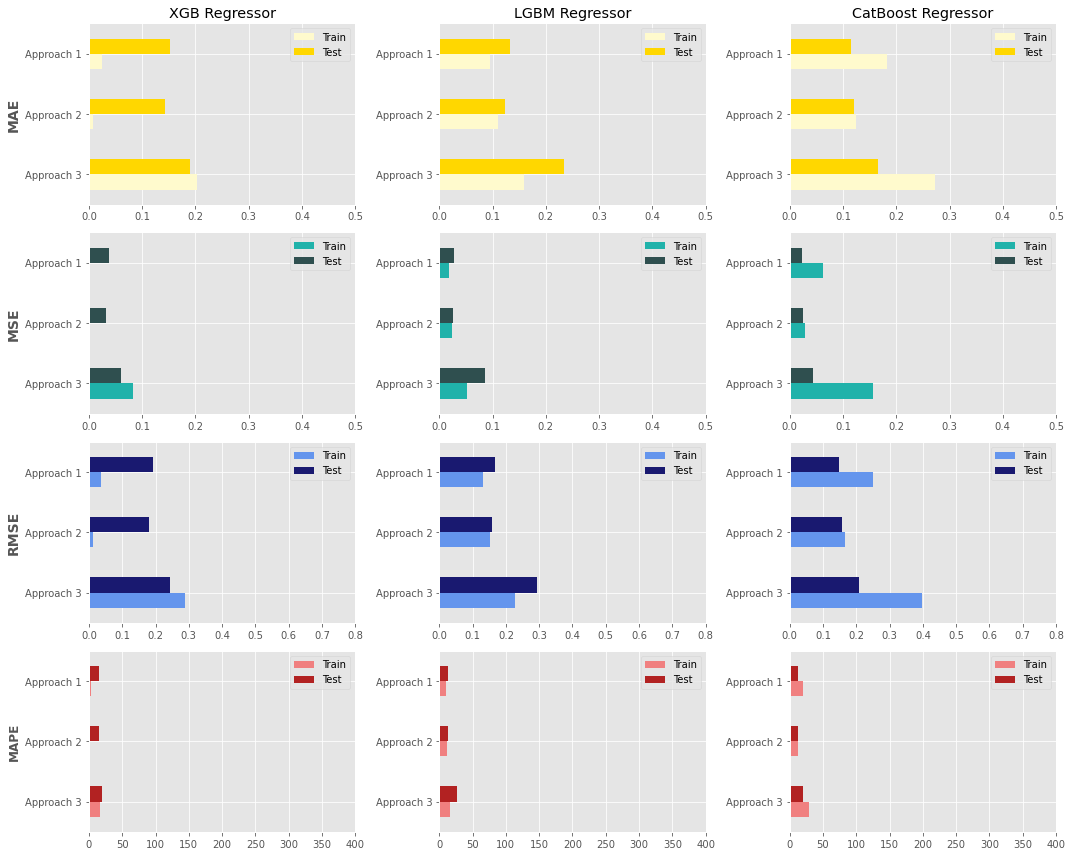

In [3216]:
fig, ax = plt.subplots(4,3,figsize=(15,12))

xgb_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'XGB Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
lgb_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'LGBM Regressor')
ctb_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'CatBoost Regressor')
xgb_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
lgb_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
ctb_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
xgb_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
lgb_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
ctb_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
xgb_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
lgb_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
ctb_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 400])
ax[3][1].set_xlim([0, 400])
ax[3][2].set_xlim([0, 400])

fig.tight_layout()

## Cross Validation

In [2796]:
aux=df.copy().reset_index()
aux=aux.sort_values('Date')
X=aux[aux.columns[3:-1]]
y=aux[aux.columns[-1]]

In [2797]:
k = 10
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    grid.fit(X_train, y_train)
    pred_values = grid.best_estimator_.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

In [2798]:
avg_acc_score

137.43982580928096

In [2799]:
acc_score

[564.4043922663354,
 40.591341526478566,
 79.81576275382736,
 132.5694850382526,
 57.9416883625423,
 76.8539418569279,
 91.31797773572757,
 114.00035642674847,
 139.97001715034727,
 76.93329497562206]